<a href="https://colab.research.google.com/github/NehaKumari500092077/IPL-Dataset/blob/master/KaggleTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
import os
import zipfile
from pathlib import Path
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Found {len(physical_devices)} GPU(s)")
    # Set memory growth on all GPUs before initializing the model
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No GPU detected. Using CPU.")

Found 1 GPU(s)


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
# ! kaggle datasets list

In [7]:
# # Configure Kaggle API (adjust the path to your kaggle.json file)
# os.environ['KAGGLE_CONFIG_DIR'] = "/path/to/your/kaggle.json"

# Download the ASL dataset using Kaggle API
! kaggle datasets download -d grassknoted/asl-alphabet

# Unzip the dataset into a structured directory with class names
with zipfile.ZipFile("asl-alphabet.zip", 'r') as zip_ref:
    zip_ref.extractall("asl_alphabet")  # This maintains the class folder structure

# Set the directory containing the class folders
asl_data_dir = Path("asl_alphabet/asl_alphabet_train/asl_alphabet_train")

# Load the images and automatically use folder names as class labels
def load_asl_images(data_dir):
    image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(128, 128),  # Resize images to 64x64, adjust as necessary
        # batch_size=32,
        label_mode='categorical'  # Categorical labels for use in multi-class classification
    )
    return image_dataset

# Load the dataset, maintaining class labels
asl_dataset = load_asl_images(asl_data_dir)



Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 98% 1.01G/1.03G [00:05<00:00, 310MB/s]
100% 1.03G/1.03G [00:05<00:00, 187MB/s]
Found 87000 files belonging to 29 classes.


In [8]:
print(os.listdir("asl_alphabet/asl_alphabet_train/asl_alphabet_train"))


['Z', 'F', 'S', 'Y', 'P', 'T', 'C', 'space', 'B', 'A', 'N', 'V', 'I', 'nothing', 'M', 'R', 'G', 'K', 'X', 'del', 'E', 'J', 'D', 'H', 'Q', 'U', 'L', 'W', 'O']


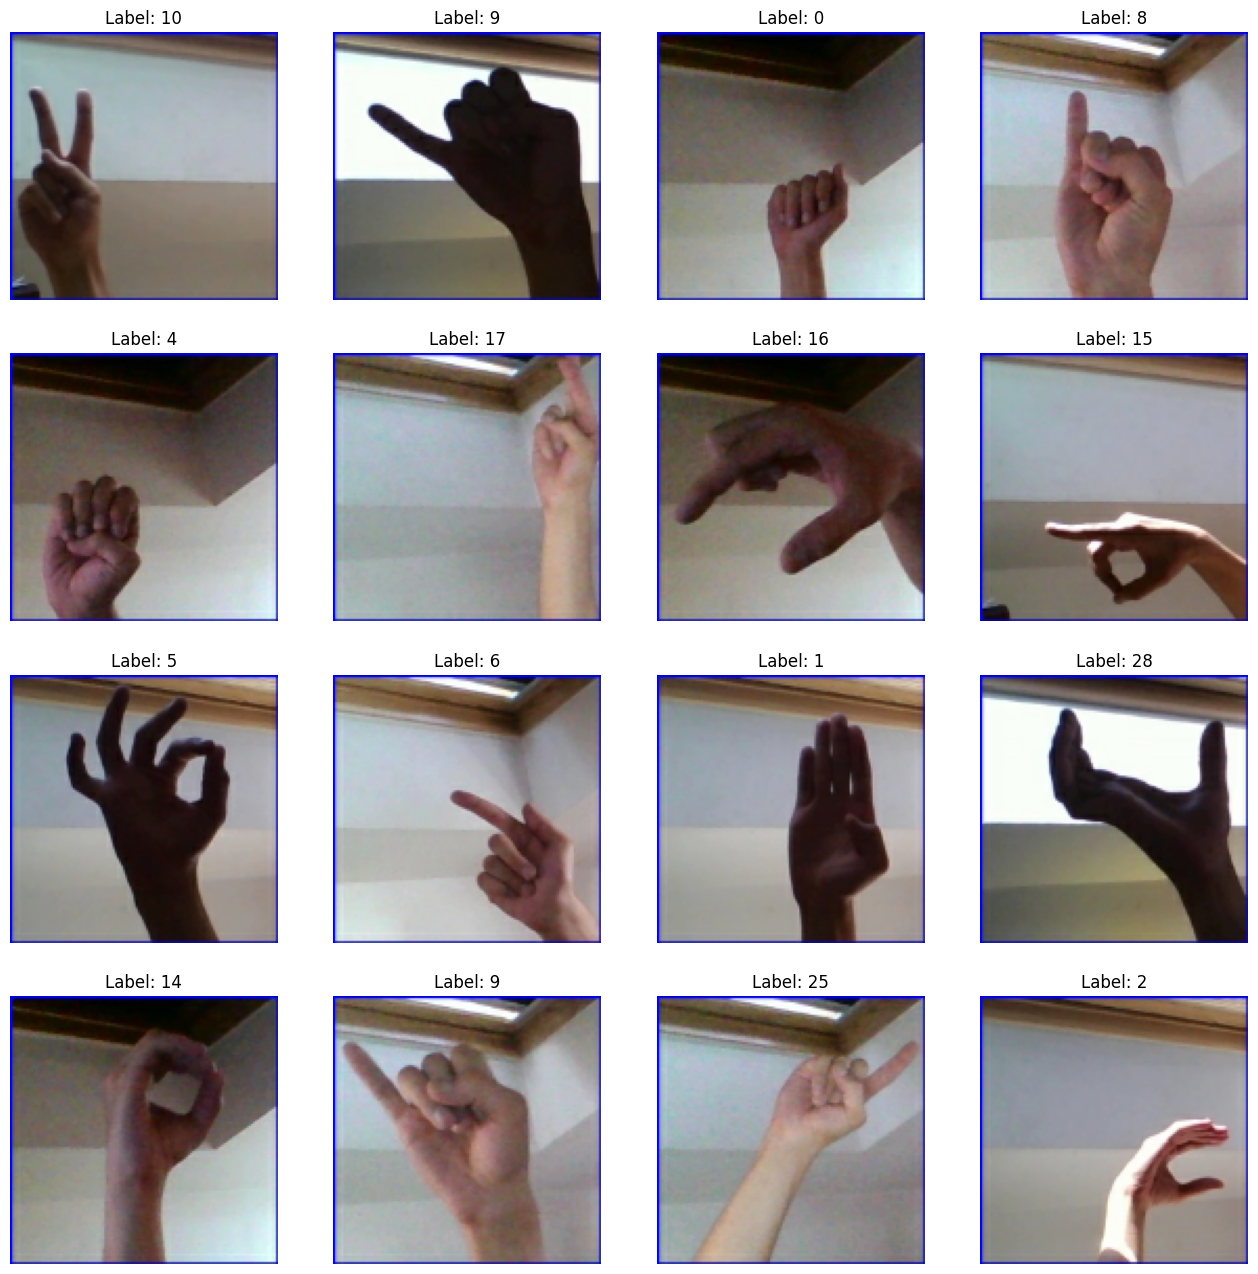

In [9]:
#show images from the loaded dataset
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to display sample images from the ASL dataset
def display_sample_images(dataset, num_images=16):
    plt.figure(figsize=(16, 16))

    # Take one batch of images and labels from the dataset
    for images, labels in dataset.take(1):
        for i in range(num_images):
            plt.subplot(4,4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))  # Convert the image to uint8 for display
            label_index = tf.argmax(labels[i]).numpy()  # Get the index of the class
            plt.title(f"Label: {label_index}")
            plt.axis("off")

    plt.show()

# Call the function to display images
display_sample_images(asl_dataset)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import gc
import psutil
print(tf.device)
with tf.device('/GPU:0'):
  # Create the Generator
  def build_generator():
      model = tf.keras.Sequential()
      model.add(layers.Dense(16 * 16 * 256, use_bias=False, input_shape=(100,)))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())

      model.add(layers.Reshape((16, 16, 256)))
      model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())

      model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
      model.add(layers.BatchNormalization())
      model.add(layers.LeakyReLU())

      model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
      return model

  # Create the Discriminator
  def build_discriminator():
      model = tf.keras.Sequential()
      model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 3]))
      model.add(layers.LeakyReLU())
      model.add(layers.Dropout(0.3))

      model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
      model.add(layers.LeakyReLU())
      model.add(layers.Dropout(0.3))

      model.add(layers.Flatten())
      model.add(layers.Dense(1))
      return model

  # Loss functions for both generator and discriminator
  cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

  def discriminator_loss(real_output, fake_output):
      real_loss = cross_entropy(tf.ones_like(real_output), real_output)
      fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
      total_loss = real_loss + fake_loss
      return total_loss

  def generator_loss(fake_output):
      return cross_entropy(tf.ones_like(fake_output), fake_output)

  # Create a directory to save generated images if it doesn't exist
  output_dir = 'generated_images'
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  # Training setup
  generator = build_generator()
  discriminator = build_discriminator()

  generator_optimizer = tf.keras.optimizers.Adam(1e-4)
  discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

  # Training loop
  EPOCHS = 10
  noise_dim = 100
  num_examples_to_generate = 16
  seed = tf.random.normal([num_examples_to_generate, noise_dim])

  # Optimized train_step with only one transposition and proper gradient management
  @tf.function
  def train_step(images, labels, noise_dim, generator, discriminator, generator_optimizer, discriminator_optimizer):
      if len(images.shape) == 5:
        images = tf.squeeze(images, axis=1)
      # Transpose images only once
      # images = tf.transpose(images, perm=[0, 2, 3, 1])  # Assuming [batch_size, height, width, channels]

      # Create noise vector for the generator
      noise = tf.random.normal([images.shape[0], noise_dim])

      # Calculate gradients using GradientTape
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=True)

          # Discriminator outputs for real and fake images
          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)

          # Calculate losses for generator and discriminator
          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

      # Compute gradients for both generator and discriminator
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

      # Apply gradients using the optimizers
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

      # Explicitly delete gradients to free up memory
      del gradients_of_generator
      del gradients_of_discriminator
      gc.collect()  # Ensure garbage collection is triggered


  def train(dataset, epochs, generator, discriminator, generator_optimizer, discriminator_optimizer, noise_dim, save_dir='models', save_frequency=5):
      # Create save directory if it doesn't exist
      if not os.path.exists(save_dir):
          os.makedirs(save_dir)

      # Iterate through epochs
      for epoch in range(epochs):
          print(f'Starting Epoch {epoch + 1}...')
          for image_batch, labels_batch in dataset:  # Unpack the tuple (image_batch, labels_batch)
              train_step(image_batch, labels_batch, noise_dim, generator, discriminator, generator_optimizer, discriminator_optimizer)

          # Optionally generate and plot images after each epoch
          generate_and_plot_images(generator, epoch + 1, seed)  # Assuming seed is predefined

          print(f'Epoch {epoch + 1} completed.')

          # Save models periodically based on frequency
          if (epoch + 1) % save_frequency == 0:
              generator.save(os.path.join(save_dir, f'generator_epoch_{epoch + 1}.h5'))
              discriminator.save(os.path.join(save_dir, f'discriminator_epoch_{epoch + 1}.h5'))

          # Monitor memory usage (optional)
          process = psutil.Process(os.getpid())
          print(f"Memory usage after Epoch {epoch + 1}: {process.memory_info().rss / 1024 / 1024} MB")

  # Optimized dataset pipeline
  def prepare_dataset(dataset, batch_size):
      dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
      return dataset

  def generate_and_plot_images(model, epoch, test_input, output_dir=output_dir):
      predictions = model(test_input, training=False)
      fig = plt.figure(figsize=(4, 4))

      for i in range(predictions.shape[0]):
          plt.subplot(4, 4, i + 1)
          plt.imshow((predictions[i] * 127.5 + 127.5) / 255.0)  # Rescale from [-1, 1] to [0, 1]
          plt.axis('off')

      plt.suptitle(f'Epoch {epoch}', fontsize=16)
      plt.savefig(f"{output_dir}/generated_image_epoch_{epoch}.png")
      plt.show()
      plt.close()  # Close the plot to free memory



<function device_v2 at 0x7f115d930310>


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting Epoch 1...


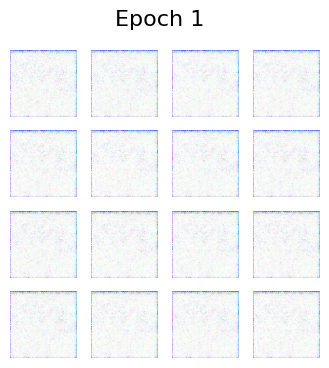

Epoch 1 completed.
Memory usage after Epoch 1: 5798.97265625 MB
Starting Epoch 2...


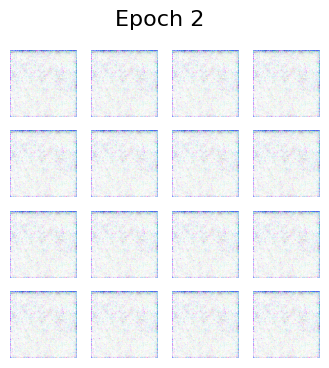

Epoch 2 completed.
Memory usage after Epoch 2: 5809.06640625 MB
Starting Epoch 3...


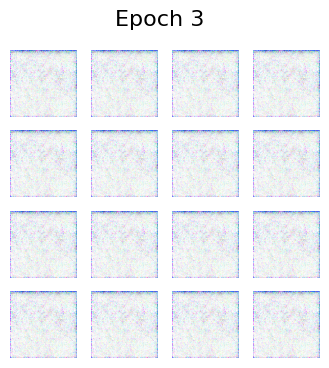

Epoch 3 completed.
Memory usage after Epoch 3: 5818.99609375 MB
Starting Epoch 4...


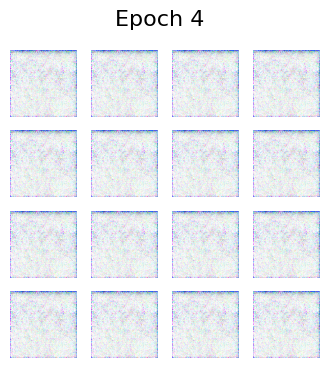

Epoch 4 completed.
Memory usage after Epoch 4: 5829.6015625 MB
Starting Epoch 5...


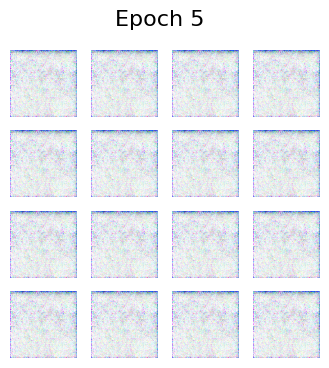

Epoch 5 completed.
Memory usage after Epoch 5: 5884.63671875 MB
Starting Epoch 6...


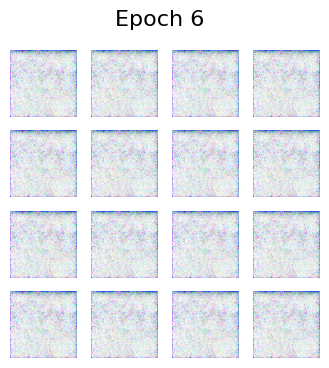

Epoch 6 completed.
Memory usage after Epoch 6: 5885.46484375 MB
Starting Epoch 7...


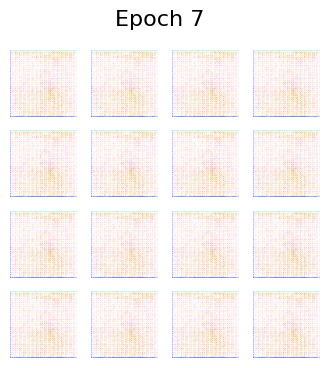

Epoch 7 completed.
Memory usage after Epoch 7: 5888.15234375 MB
Starting Epoch 8...


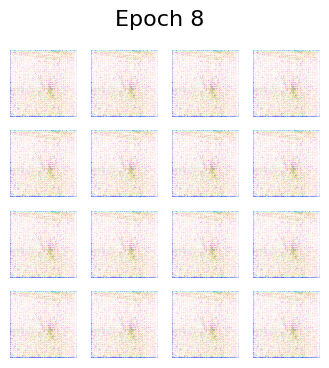

Epoch 8 completed.
Memory usage after Epoch 8: 5888.578125 MB
Starting Epoch 9...


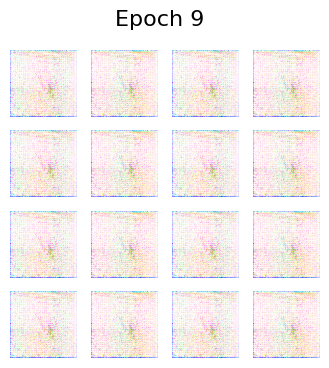

Epoch 9 completed.
Memory usage after Epoch 9: 5890.1640625 MB
Starting Epoch 10...


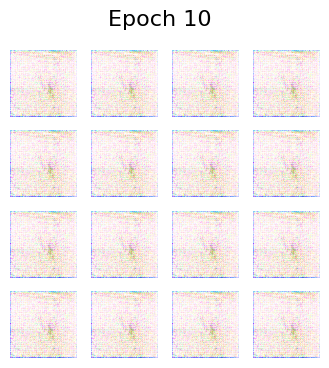

Epoch 10 completed.
Memory usage after Epoch 10: 5868.828125 MB


In [11]:
# Use the previously loaded ASL dataset
BUFFER_SIZE = 500
BATCH_SIZE = 64

noise_dim = 100

# Prepare the dataset for training
train_dataset = asl_dataset.shuffle(BUFFER_SIZE)

# Train the GAN
train(train_dataset, EPOCHS, generator, discriminator, generator_optimizer, discriminator_optimizer, noise_dim)